In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from cmcrameri import cm
from matplotlib import colors
import matplotlib.patches as patches
from scipy import signal
import peakutils
import math
import json
from os.path import expanduser
import glob
import os
import alphatims.bruker

In [2]:
experiment_name = 'P3856'
run_name = 'P3856_YHE211_1_Slot1-1_1_5104'

minvi = 5000
FEATURES_DIR = sorted(glob.glob('/media/data-4t-a/results-P3856-3did/minvi-{}-*/features-3did'.format(minvi)))[-1]
FEATURES_FILE = '{}/exp-{}-run-{}-features-3did-dedup.feather'.format(FEATURES_DIR, experiment_name, run_name)

In [3]:
FEATURES_FILE

'/media/data-4t-a/results-P3856-3did/minvi-5000-2021-09-19-13-17-18/features-3did/exp-P3856-run-P3856_YHE211_1_Slot1-1_1_5104-features-3did-dedup.feather'

#### select a feature, or the stopping point

In [4]:
features_df = pd.read_feather(FEATURES_FILE)

In [5]:
len(features_df)

32358

In [6]:
# select a random feature of the most intense
features_df.sort_values(by=['feature_intensity'], ascending=False, inplace=True)
features_df.head(n=100).sample(n=3)[['feature_id','feature_intensity']]

,feature_id,feature_intensity
7846,12755,91036
24941,44691,97005
9217,14962,83062


In [7]:
# select a random feature of the least intense
features_df.tail(n=100).sample(n=3)[['feature_id','feature_intensity']]

,feature_id,feature_intensity
16350,27337,978
9769,15738,979
3215,4640,978


In [8]:
features_df[(features_df.voxel_id >= 960000000) & (features_df.voxel_id <= 960000050)].sort_values(by=['voxel_id'], ascending=True)

,index,mono_mz_lower,mono_mz_upper,scan_apex,scan_lower,scan_upper,rt_apex,rt_lower,rt_upper,intensity_without_saturation_correction,...,feature_region_3d_extent,voxel_id,voxel_metadata_d,scan_df,scan_r_squared,rt_df,rt_r_squared,feature_id,prediction,identification_predicted
28008,0,1050.024902,1050.091797,165.0,130.0,175.0,2064.316162,2060.083984,2067.491455,47185,...,"{""mz_lower"": 1049.046645, ""mz_upper"": 1053.05,...",960000001,"{""mz_lower"": 1050.0, ""mz_upper"": 1050.1, ""scan...","[{""scan"":128,""intensity"":1461,""filtered_intens...",0.994388,"[{""frame_id"":18392,""retention_time_secs"":2050....",0.997807,50639,0.879542,True
28009,1,1052.995605,1053.062622,197.0,187.0,207.0,2192.924316,2189.750488,2196.100098,54708,...,"{""mz_lower"": 1052.546645, ""mz_upper"": 1056.55,...",960000003,"{""mz_lower"": 1053.5, ""mz_upper"": 1053.6, ""scan...","[{""scan"":158,""intensity"":8441,""filtered_intens...",0.996581,"[{""frame_id"":19622,""retention_time_secs"":2180....",0.996613,50640,0.996048,True
28010,5,1057.020386,1057.087769,128.0,98.0,157.0,2177.047852,2174.403564,2179.694092,44316,...,"{""mz_lower"": 1056.5466450000001, ""mz_upper"": 1...",960000019,"{""mz_lower"": 1057.5, ""mz_upper"": 1057.60000000...","[{""scan"":88,""intensity"":284,""filtered_intensit...",0.998581,"[{""frame_id"":19482,""retention_time_secs"":2165....",0.995769,50644,0.979553,True
28011,6,1056.939819,1057.007202,184.0,154.0,215.0,1888.088867,1885.972046,1890.738647,43956,...,"{""mz_lower"": 1056.446645, ""mz_upper"": 1060.45,...",960000022,"{""mz_lower"": 1057.4, ""mz_upper"": 1057.5, ""scan...","[{""scan"":148,""intensity"":242,""filtered_intensi...",0.996782,"[{""frame_id"":16742,""retention_time_secs"":1875....",0.993717,50645,0.990793,True
28012,7,1058.410278,1058.477783,247.0,221.0,272.0,1819.817993,1817.172607,1822.994263,38826,...,"{""mz_lower"": 1057.946645, ""mz_upper"": 1061.95,...",960000031,"{""mz_lower"": 1058.9, ""mz_upper"": 1059.0, ""scan...","[{""scan"":208,""intensity"":259,""filtered_intensi...",0.985496,"[{""frame_id"":16077,""retention_time_secs"":1805....",0.994708,50646,0.977478,True
28013,8,1058.967285,1059.034790,203.0,171.0,213.0,2165.935791,2162.759277,2169.110596,45099,...,"{""mz_lower"": 1058.5466450000001, ""mz_upper"": 1...",960000032,"{""mz_lower"": 1059.5, ""mz_upper"": 1059.60000000...","[{""scan"":168,""intensity"":1191,""filtered_intens...",0.997816,"[{""frame_id"":19387,""retention_time_secs"":2155....",0.997400,50647,0.995594,True


In [9]:
selected_feature = features_df.loc[28010].copy()

In [10]:
selected_feature

index                                                                                      5
mono_mz_lower                                                                    1057.020386
mono_mz_upper                                                                    1057.087769
scan_apex                                                                              128.0
scan_lower                                                                              98.0
scan_upper                                                                             157.0
rt_apex                                                                          2177.047852
rt_lower                                                                         2174.403564
rt_upper                                                                         2179.694092
intensity_without_saturation_correction                                                44316
intensity_with_saturation_correction                                  

In [11]:
# all features from the same voxel
features_df[(features_df.voxel_id == selected_feature.voxel_id)][['monoisotopic_mz','scan_apex','rt_apex','voxel_id','voxels_processed']]

,monoisotopic_mz,scan_apex,rt_apex,voxel_id,voxels_processed
28010,1057.054321,128.0,2177.047852,960000019,"[960000132, 960000072, 960000447, 960005130, 9..."


In [12]:
# convert the metadata JSON to dicts
selected_feature.voxel_metadata_d = json.loads(selected_feature.voxel_metadata_d)
selected_feature.feature_region_3d_extent = json.loads(selected_feature.feature_region_3d_extent)

#### inspect the voxels used for this peak

#### isotope extent in mobility

In [13]:
scan_df = pd.read_json(selected_feature.scan_df)

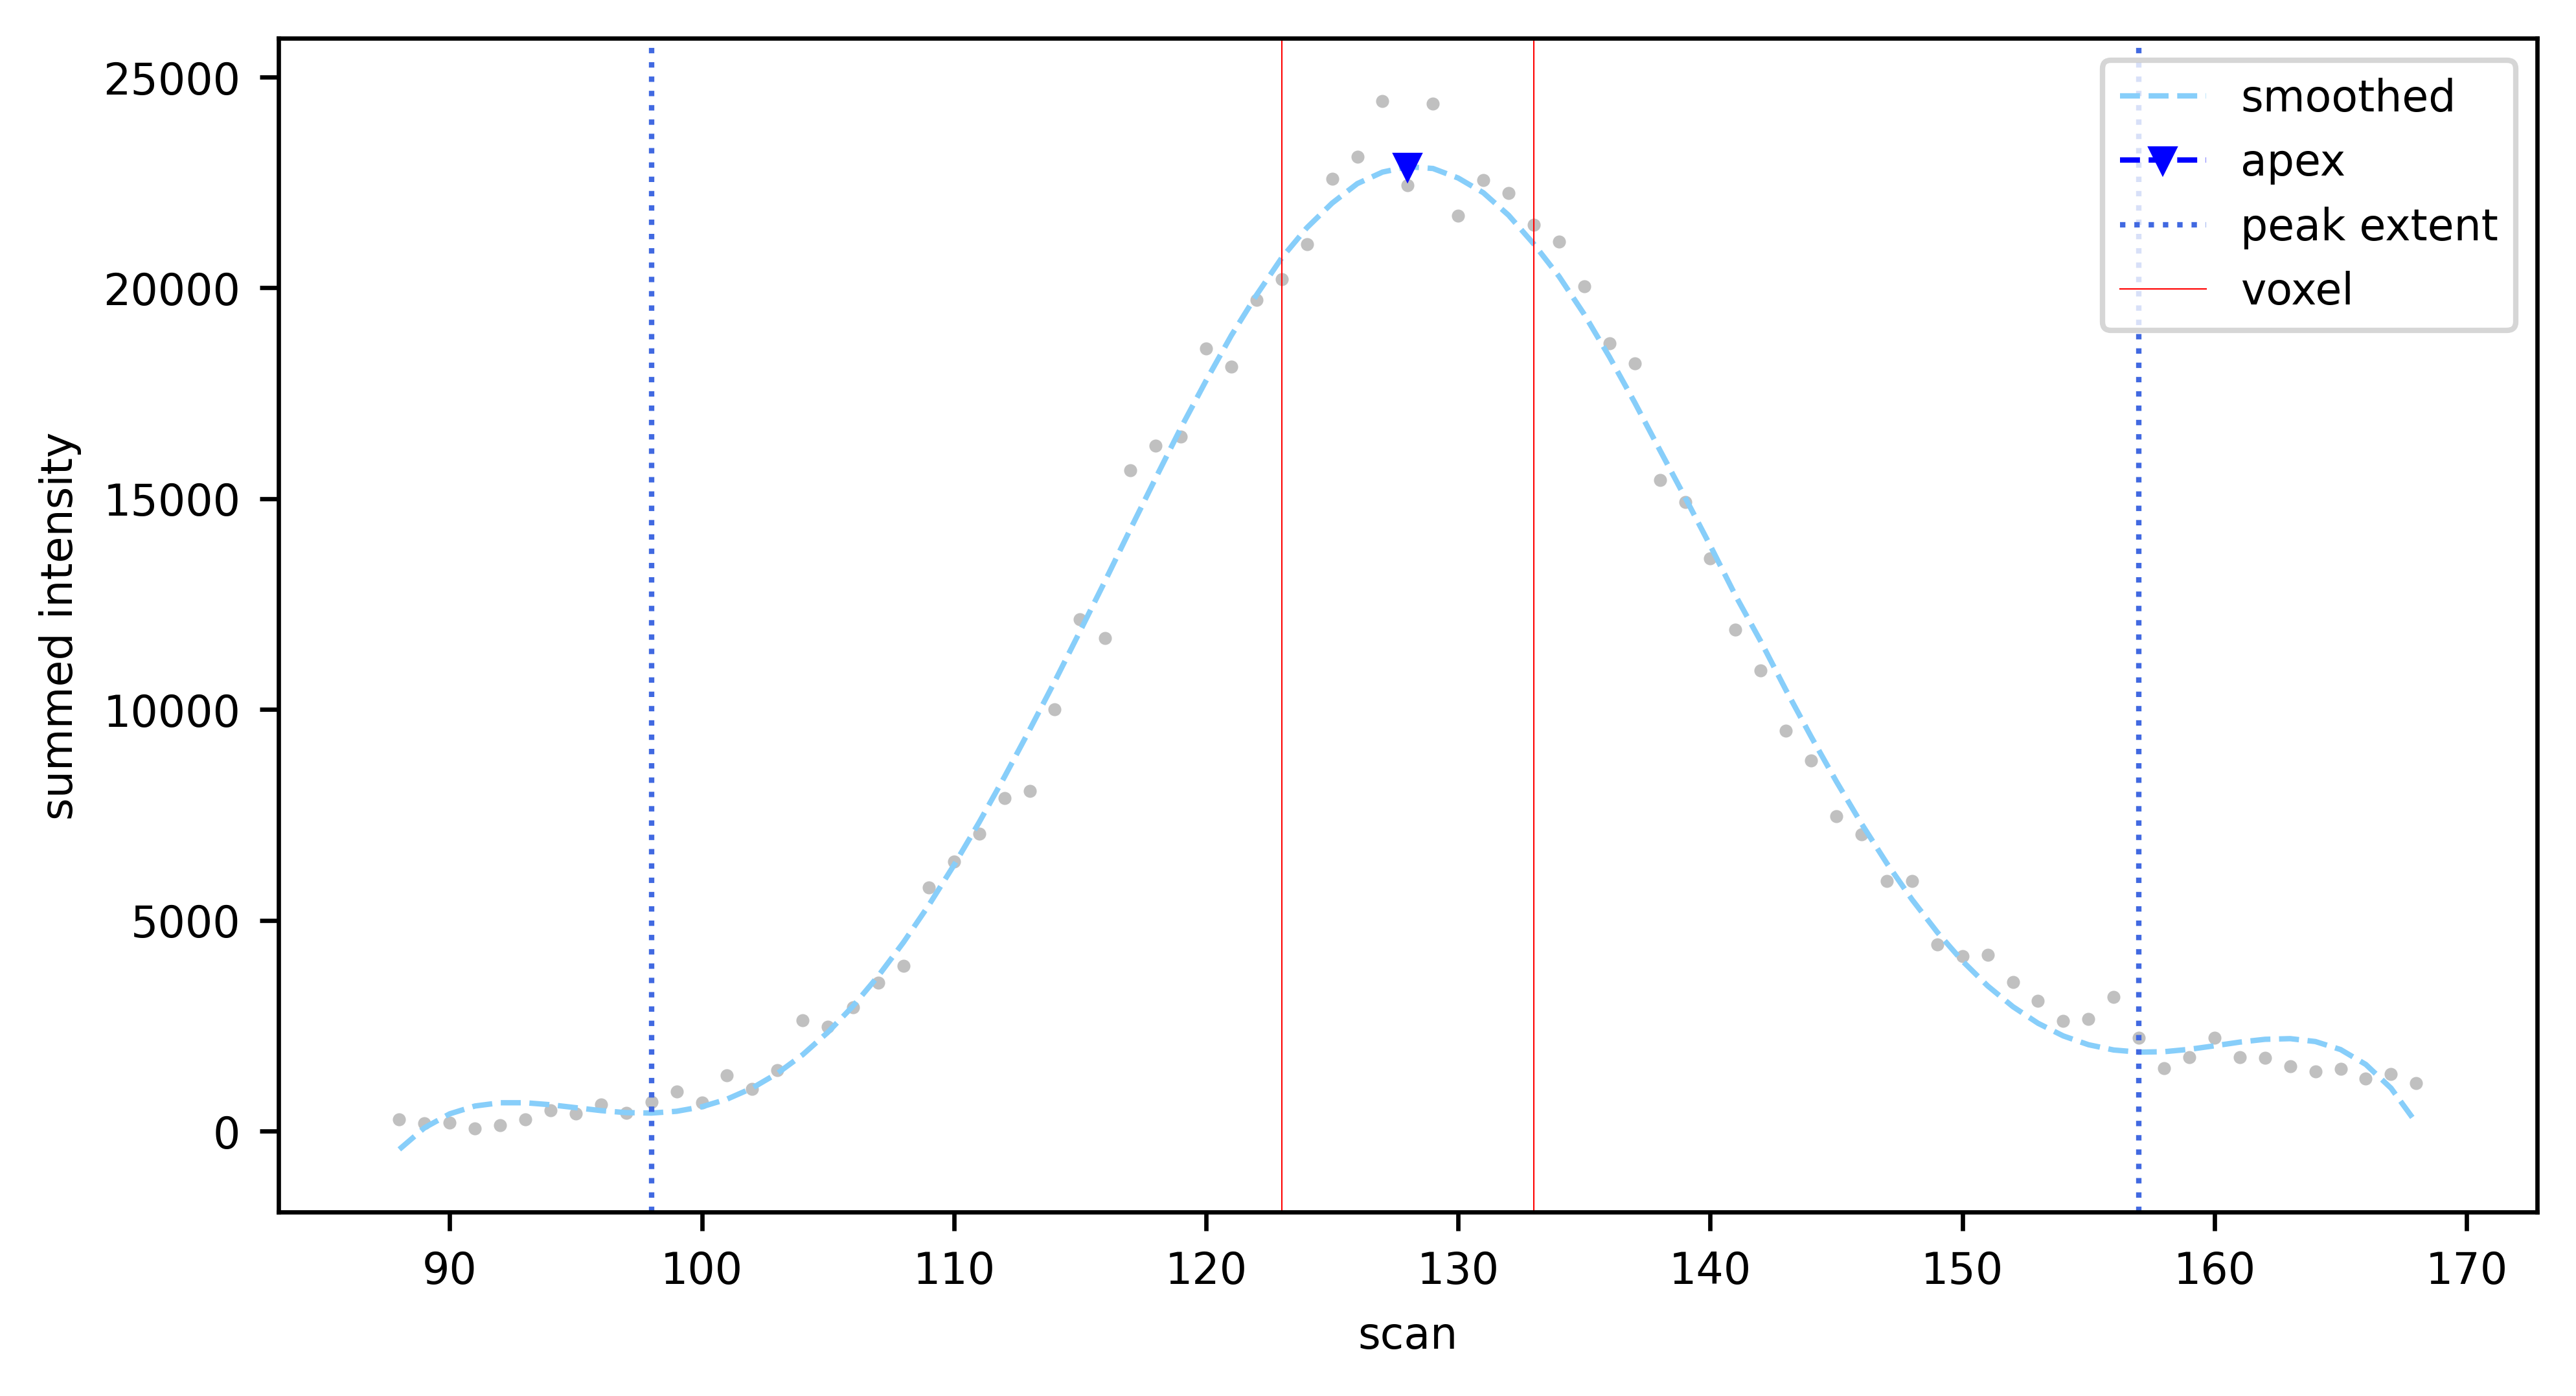

In [14]:
f, ax1 = plt.subplots()
f.set_figheight(4)
f.set_figwidth(7.5)
f.set_dpi(600)

plt.margins(0.06)

# plot the flattened points
plt.scatter(scan_df.scan, scan_df.intensity, c='silver', s=2)
# plot the smoothed points
plt.plot(scan_df.scan, scan_df.filtered_intensity, marker='', color='lightskyblue', linestyle='--', linewidth=1, ms=5, label='smoothed')

plt.plot(selected_feature.scan_apex, scan_df[scan_df.scan==selected_feature.scan_apex].iloc[0].clipped_filtered_intensity, marker='v', color='blue', linestyle='--', linewidth=1, ms=4, label='apex')

plt.axvline(x=selected_feature.scan_lower, linestyle=':', color='royalblue', linewidth=1, label='peak extent')
plt.axvline(x=selected_feature.scan_upper, linestyle=':', color='royalblue', linewidth=1)

plt.axvline(x=selected_feature.voxel_metadata_d['scan_lower'], linestyle='-', color='red', linewidth=0.25, label='voxel')
plt.axvline(x=selected_feature.voxel_metadata_d['scan_upper'], linestyle='-', color='red', linewidth=0.25)

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# plt.title('apex in the mobility dimension for voxel\'s midpoint, feature {}'.format(selected_feature.feature_id))
plt.legend(fontsize=8)
plt.xlabel("scan", fontsize=8)
plt.ylabel("summed intensity", fontsize=8)
plt.show()

In [15]:
f.savefig('{}/3did-figure-5a.tiff'.format(expanduser('~')), dpi=600, bbox_inches='tight')

In [16]:
print(selected_feature.scan_r_squared)

0.9985805


#### isotope extent in retention time

In [17]:
rt_df = pd.read_json(selected_feature.rt_df)

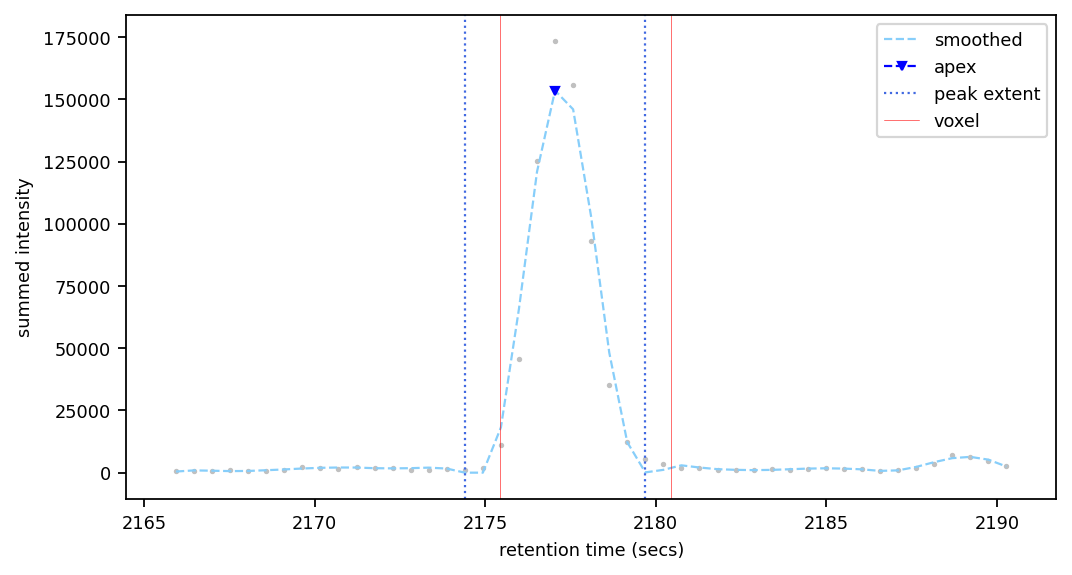

In [18]:
f, ax1 = plt.subplots()
f.set_figheight(4)
f.set_figwidth(7.5)
f.set_dpi(160)

plt.margins(0.06)

# plot the flattened points
plt.scatter(rt_df.retention_time_secs, rt_df.intensity, c='silver', s=2)
# plot the smoothed points
plt.plot(rt_df.retention_time_secs, rt_df.clipped_filtered_intensity, marker='', color='lightskyblue', linestyle='--', linewidth=1, ms=2, label='smoothed')

plt.plot(selected_feature.rt_apex, rt_df[np.isclose(rt_df.retention_time_secs, selected_feature.rt_apex)].iloc[0].clipped_filtered_intensity, marker='v', color='blue', linestyle='--', linewidth=1, ms=4, label='apex')

plt.axvline(x=selected_feature.rt_lower, linestyle=':', color='royalblue', linewidth=1, label='peak extent')
plt.axvline(x=selected_feature.rt_upper, linestyle=':', color='royalblue', linewidth=1)

plt.axvline(x=selected_feature.voxel_metadata_d['rt_lower'], linestyle='-', color='red', linewidth=0.25, label='voxel')
plt.axvline(x=selected_feature.voxel_metadata_d['rt_upper'], linestyle='-', color='red', linewidth=0.25)

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# plt.title('apex in the retention time dimension, feature {}'.format(selected_feature.feature_id))
plt.legend(fontsize=8)
plt.xlabel("retention time (secs)", fontsize=8)
plt.ylabel("summed intensity", fontsize=8)
plt.show()

In [19]:
f.savefig('{}/3did-figure-5b.tiff'.format(expanduser('~')), dpi=600, bbox_inches='tight')

In [20]:
print(selected_feature.rt_r_squared)

0.99576867


#### feature region in the voxel's most intense frame

In [21]:
rt_lower = selected_feature.rt_apex-20
rt_upper = selected_feature.rt_apex+20
scan_lower = int(min(selected_feature.scan_lower, selected_feature.scan_apex-30, selected_feature.voxel_metadata_d['scan_lower'], selected_feature.feature_region_3d_extent['scan_lower']))
scan_upper = int(max(selected_feature.scan_upper, selected_feature.scan_apex+30, selected_feature.voxel_metadata_d['scan_upper'], selected_feature.feature_region_3d_extent['scan_upper']))
mz_lower = min(selected_feature.feature_region_3d_extent['mz_lower'], selected_feature.monoisotopic_mz-1.0)
mz_upper = max(selected_feature.feature_region_3d_extent['mz_upper'], selected_feature.monoisotopic_mz+4.0)

In [22]:
RAW_DATABASE_NAME = '/media/big-ssd/experiments/P3856/raw-databases/P3856_YHE211_1_Slot1-1_1_5104.d'
RAW_HDF_PATH = RAW_DATABASE_NAME.replace('.d','.hdf')

In [23]:
# create the TimsTOF object
if not os.path.isfile(RAW_HDF_PATH):
    print('{} doesn\'t exist so loading the raw data from {}'.format(RAW_HDF_PATH, RAW_DATABASE_NAME))
    data = alphatims.bruker.TimsTOF(RAW_DATABASE_NAME)
    print('saving to {}'.format(RAW_HDF_PATH))
    _ = data.save_as_hdf(
        directory=os.path.split(RAW_HDF_PATH)[0],
        file_name=os.path.split(RAW_HDF_PATH)[1],
        overwrite=True
    )
else:
    print('loading raw data from {}'.format(RAW_HDF_PATH))
    data = alphatims.bruker.TimsTOF(RAW_HDF_PATH)

loading raw data from /media/big-ssd/experiments/P3856/raw-databases/P3856_YHE211_1_Slot1-1_1_5104.hdf


In [24]:
raw_df = data[
    {
        "rt_values": slice(rt_lower, rt_upper),
        "mz_values": slice(mz_lower, mz_upper),
        "scan_indices": slice(scan_lower, scan_upper),
        "precursor_indices": 0,
    }
][['mz_values','scan_indices','frame_indices','rt_values','intensity_values']]
raw_df.rename(columns={'mz_values':'mz', 'scan_indices':'scan', 'frame_indices':'frame_id', 'rt_values':'retention_time_secs', 'intensity_values':'intensity'}, inplace=True)
# downcast the data types to minimise the memory used
int_columns = ['frame_id','scan','intensity']
raw_df[int_columns] = raw_df[int_columns].apply(pd.to_numeric, downcast="unsigned")
float_columns = ['retention_time_secs']
raw_df[float_columns] = raw_df[float_columns].apply(pd.to_numeric, downcast="float")

In [25]:
voxel_midpoint_rt_lower = selected_feature.voxel_metadata_d['voxel_rt_midpoint'] - 0.3
voxel_midpoint_rt_upper = selected_feature.voxel_metadata_d['voxel_rt_midpoint'] + 0.3
voxel_most_intense_frame_df = raw_df[(raw_df.retention_time_secs >= voxel_midpoint_rt_lower) & (raw_df.retention_time_secs <= voxel_midpoint_rt_upper)]

In [26]:
voxel_mz_lower = selected_feature.voxel_metadata_d['mz_lower']
voxel_mz_upper = selected_feature.voxel_metadata_d['mz_upper']
voxel_scan_lower = selected_feature.voxel_metadata_d['scan_lower']
voxel_scan_upper = selected_feature.voxel_metadata_d['scan_upper']

In [27]:
base_peak_mz_lower = selected_feature.voxel_metadata_d['iso_mz_lower']
base_peak_mz_upper = selected_feature.voxel_metadata_d['iso_mz_upper']
base_peak_scan_lower = selected_feature.feature_region_3d_extent['scan_lower']
base_peak_scan_upper = selected_feature.feature_region_3d_extent['scan_upper']

In [28]:
feature_region_mz_lower = selected_feature.feature_region_3d_extent['mz_lower']
feature_region_mz_upper = selected_feature.feature_region_3d_extent['mz_upper']
feature_region_scan_lower = selected_feature.feature_region_3d_extent['scan_lower']
feature_region_scan_upper = selected_feature.feature_region_3d_extent['scan_upper']
feature_region_rt_lower = selected_feature.feature_region_3d_extent['rt_lower']
feature_region_rt_upper = selected_feature.feature_region_3d_extent['rt_upper']

In [29]:
# create the colour map to convert intensity to colour
colour_map = cm.batlow_r
norm = colors.LogNorm(vmin=voxel_most_intense_frame_df.intensity.min(), vmax=voxel_most_intense_frame_df.intensity.max(), clip=True)

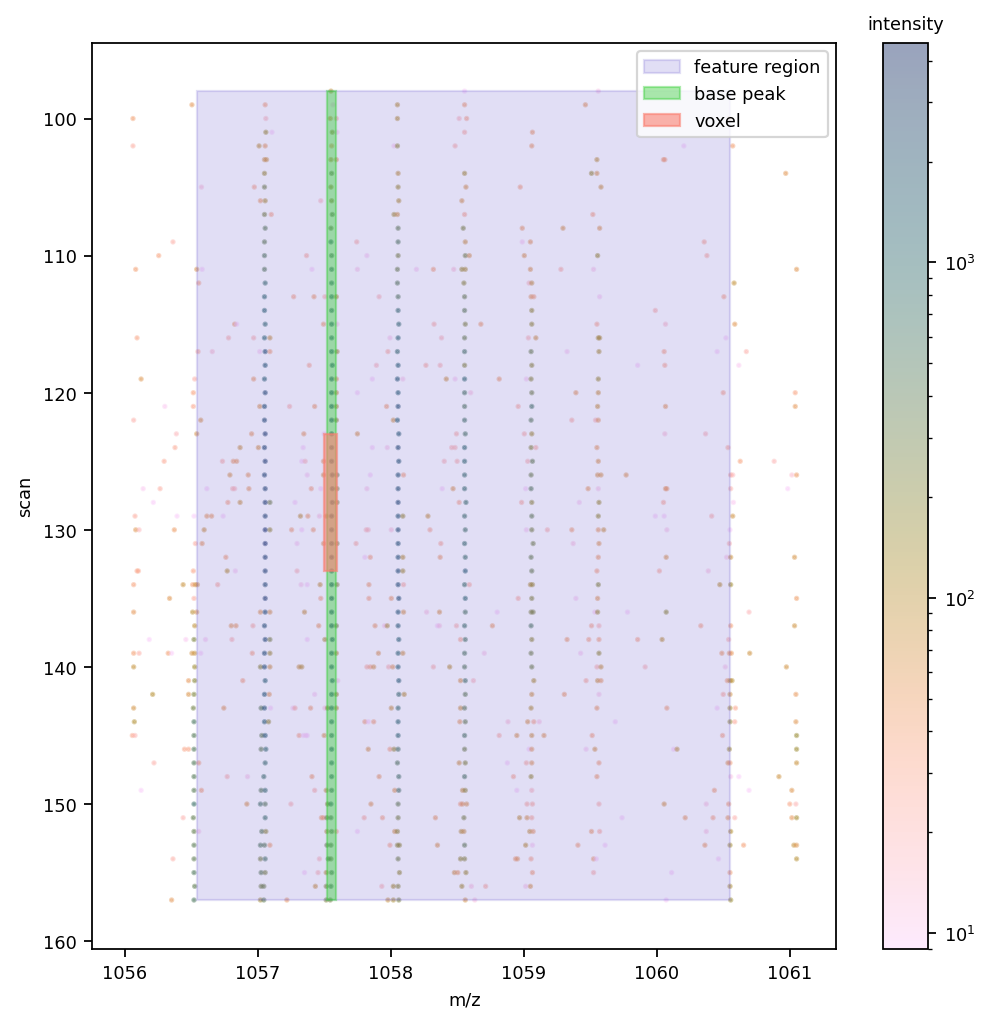

In [30]:
f, ax1 = plt.subplots()
f.set_figheight(7.5)
f.set_figwidth(7.5)
f.set_dpi(160)

plt.margins(0.06)

plt.scatter(voxel_most_intense_frame_df.mz, voxel_most_intense_frame_df.scan, c=voxel_most_intense_frame_df.intensity, cmap=colour_map, norm=norm, alpha=0.4, s=2, linewidths=None, edgecolors=None)
# plt.plot(ap_mz, ap_scan, marker='x', markerfacecolor='none', markeredgecolor='red', linestyle='', markeredgewidth=5, ms=25, alpha=0.6, label='anchor point')

# draw the feature region for deconvolution
top_left = (feature_region_mz_lower,feature_region_scan_lower)
width = feature_region_mz_upper - feature_region_mz_lower
height = feature_region_scan_upper - feature_region_scan_lower
cuboid_rect = patches.Rectangle(top_left,width,height,linewidth=1.0,linestyle='-',edgecolor='slateblue',facecolor='slateblue',alpha=0.2,label='feature region')
ax1.add_patch(cuboid_rect)

# draw the base peak
top_left = (base_peak_mz_lower,base_peak_scan_lower)
width = base_peak_mz_upper - base_peak_mz_lower
height = base_peak_scan_upper - base_peak_scan_lower
cuboid_rect = patches.Rectangle(top_left,width,height,linewidth=1.0,linestyle='-',edgecolor='limegreen',facecolor='limegreen',alpha=0.4,label='base peak')
ax1.add_patch(cuboid_rect)

# draw the voxel
top_left = (voxel_mz_lower,voxel_scan_lower)
width = voxel_mz_upper - voxel_mz_lower
height = voxel_scan_upper - voxel_scan_lower
cuboid_rect = patches.Rectangle(top_left,width,height,linewidth=1.0,linestyle='-',edgecolor='salmon',facecolor='salmon',alpha=0.6,label='voxel')
ax1.add_patch(cuboid_rect)

plt.xlabel("m/z", fontsize=8)
plt.ylabel("scan", fontsize=8)

nearest = 1.0
range_l = round(voxel_most_intense_frame_df.mz.min() / nearest) * nearest
range_u = round(voxel_most_intense_frame_df.mz.max() / nearest) * nearest
plt.xticks(np.arange(range_l,range_u+nearest,nearest), fontsize=8)

nearest = 10.0
range_l = round(voxel_most_intense_frame_df.scan.min() / nearest) * nearest
range_u = round(voxel_most_intense_frame_df.scan.max() / nearest) * nearest
plt.yticks(np.arange(range_l,range_u+nearest,nearest), fontsize=8)

# plt.title('feature region around the voxel\'s midpoint, feature {}, RT {} secs'.format(selected_feature.feature_id, round(selected_feature.voxel_metadata_d['voxel_rt_midpoint'],1)))

# plot colorbar
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=8)
cbar.ax.set_title('intensity', fontsize=8)

plt.legend(fontsize=8)
plt.gca().invert_yaxis()
plt.show()

In [31]:
f.savefig('{}/3did-figure-4.tiff'.format(expanduser('~')), dpi=600, bbox_inches='tight')

#### spectra deconvolution

In [32]:
feature_region_raw_df = raw_df[(raw_df.mz >= feature_region_mz_lower) & (raw_df.mz <= feature_region_mz_upper) & (raw_df.scan >= feature_region_scan_lower) & (raw_df.scan <= feature_region_scan_upper) & (raw_df.retention_time_secs >= feature_region_rt_lower) & (raw_df.retention_time_secs <= feature_region_rt_upper)].copy()
feature_region_raw_df['normalised_intensity'] = feature_region_raw_df.intensity / feature_region_raw_df.intensity.max()

In [33]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Rescale to values between 0 and 1
tableau20_mpl = tableau20.copy()
for i in range(len(tableau20_mpl)):  
    r, g, b = tableau20_mpl[i]  
    tableau20_mpl[i] = (r / 255., g / 255., b / 255.)

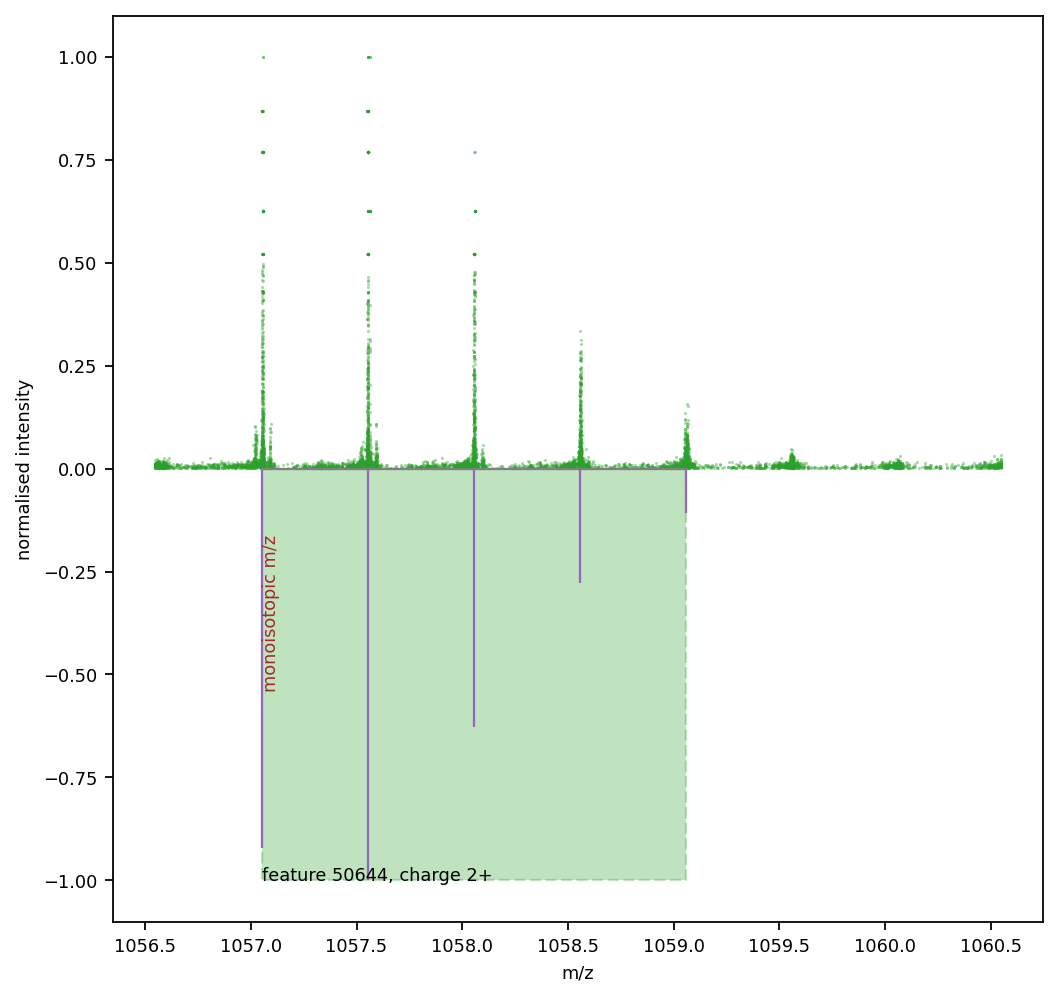

In [40]:
f, ax = plt.subplots()
f.set_figheight(7.5)
f.set_figwidth(7.5)
f.set_dpi(160)

# plot the raw data
ax.scatter(feature_region_raw_df.mz, feature_region_raw_df.normalised_intensity, marker='o', color='tab:green', lw=0, s=2, alpha=0.4)

# plot the feature's bounding rectangle
envelope = json.loads(selected_feature.envelope)
env_width = envelope[-1][0] - envelope[0][0]
rect_colour = tableau20_mpl[4]
rect = patches.Rectangle((envelope[0][0],0),env_width,-1.0,linewidth=1,linestyle=(0,(5,2)),edgecolor=rect_colour+(0.3,),facecolor=rect_colour+(0.3,),fill=True)
ax.add_patch(rect)
ax.text(x=envelope[0][0], y=-1.0, s='feature {}, charge {}+'.format(selected_feature.feature_id, selected_feature.charge), size=8)

# determine the peaks from the envelope
envelope_df = pd.DataFrame(envelope, columns=['mz','intensity'])
envelope_df['normalised_intensity'] = envelope_df.intensity / envelope_df.intensity.max()

# plot the peaks from deconvolution
markerline, stemlines, baseline = ax.stem(envelope_df.mz, -envelope_df.normalised_intensity, markerfmt=" ", use_line_collection=True)
plt.setp(markerline, 'color', 'tab:purple')
plt.setp(stemlines, 'color', 'tab:purple')
plt.setp(baseline, 'color', 'tab:gray')
plt.setp(stemlines, 'linewidth', 1)
plt.setp(baseline, 'linewidth', 1)

# show the monoisotopic m/z determined by deconvolution
text_style = dict(size=8, color='brown', verticalalignment='center', horizontalalignment='left')
ax.text(selected_feature.monoisotopic_mz, -0.35, "monoisotopic m/z", **text_style, rotation='vertical')

nearest = 0.5
range_l = round(feature_region_raw_df.mz.min() / nearest) * nearest
range_u = round(feature_region_raw_df.mz.max() / nearest) * nearest
plt.xticks(np.arange(range_l,range_u+nearest,nearest), fontsize=8)
plt.yticks(fontsize=8)

ax.set_xlabel('m/z', fontsize=8)
ax.set_ylabel('normalised intensity', fontsize=8)

ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)

# ax.set_title('spectra for feature {}, monoisotopic peak at {} m/z, charge {}+, deconvolution score: {}'.format(selected_feature.feature_id, round(selected_feature.mono_mz,4), selected_feature.charge, round(selected_feature.deconvolution_score,1)))

plt.show()

In [39]:
f.savefig('{}/3did-figure-5c.tiff'.format(expanduser('~')), dpi=600, bbox_inches='tight')